<a href="https://colab.research.google.com/github/hallmx/learning_ML/blob/master/UCI_Heart_Disease_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UCI Heart disease: The full EDA

In this notebook we perfrom a detailed EDA of the Full 4 Center UCI Heart Disease Dataset using data visualizations and basic domain knowledge. We use the results to select features for a machine learning pipeline and then use the final dataset to train a number of common classifiers. Results are comparable to those obtained from automated feature selection methods on the same dataset and classifiers.

In [0]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
root_dir = "/content/gdrive/My Drive/"

## Library imports & notebook setup

In [0]:
# common imports 
import os
import numpy as np
import pandas as pd
import statistics 
# For stats
from scipy.stats import pearsonr, spearmanr
# For plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# machine learning
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, roc_auc_score, roc_curve, confusion_matrix
from xgboost import XGBClassifier

In [0]:
# Manage warnings
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)

In [0]:
# view all columns at full width when displaying dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

In [0]:
# Set plot style
plt.style.use('seaborn-darkgrid')

## Get the 4 center unprocessed UCI Heart Disease datasets

The complete original datsets from each of the 4 centers (Clevealnd, Switzerland, Hungray and VA) are also available for download from the UCI Heart website but are in the form of .data files which we will need to process a bit in order to get into a a form we can work with. 

We will call this dataset the 'UCI 4 center full datset' or 'heart_full'

In [146]:
# Get dataset and view 
root_dir = '/content/gdrive/My Drive'
data_path = root_dir+"/learning_ML/datasets"
path = data_path+"/UCI_HeartDiseaseFull"
os.listdir(path)

['cleveland.data',
 'switzerland.data',
 'va.data',
 'hungarian.data',
 'colnames.names']

In [0]:
# Unprocessed data is in .data files and consists of tab separated values in rows separated by '\n'
# Function takes in the unprocessed data files and returns a standard dataframe 
def create_df(data):
    rows = data.decode("utf-8", errors="ignore").replace("\n", " ").replace(" ", ",").replace("name", "\n").split('\n')
    data_arr = []
    for i, r in enumerate(rows):
        r = r[:-1]
        if i > 0: r = r[1:]
        r_split=r.split(",")
        if len(r_split) == 75:
            row = []
            for j in range(75):
                row.append(float(r_split[j]))
            data_arr.append(list(row))

    df = pd.DataFrame(data=data_arr)
    return df

In [148]:
# Load unprocesed data, call create_df to process it into a dataframe
# Combine the four datsets into a single dataframe with column names
heart_df = pd.DataFrame()
for i, filename in enumerate(os.listdir(path)):
  if str(filename) != "colnames.names":
      with open(path+"/"+filename, 'rb') as f:
          data = f.read()
          df = create_df(data)
          src_col = str(filename[:3])
          if len(df.columns) > 0: df.insert(2, "src", src_col)
          heart_df = pd.concat([heart_df, df], axis=0)
            
# Attributes and their meanings are given in a separate file: 
heart_df = heart_df.reset_index()      
cols = ['src_idx', 'pt_id', 'ccf','src', 'age', 'sex', 'painloc', 'painexer', 'relrest', 'pncaden', 'cptype', 'restbp', 'htn', 'chol', 
        'smoke', 'cigsday', 'cigsyrs', 'fastsug', 'dm','famhist', 'restecg', 'ekgmo', 'ekgday', 'ekgyr', 'dig', 'prop', 
        'nitr', 'pro', 'diuretic', 'protocol', 'thaldur', 'thaltime','met', 'thalach', 'thalrest', 'tpeakbps', 'tpeakbpd', 'dummy', 
        'trestbpd', 'exang', 'xhypo', 'oldpeak', 'slope', 'rldv5', 'rldv5e', 'ca', 'restckm', 'exerckm', 'restef', 'restwm', 
        'exeref', 'exerwm', 'thal', 'nu1', 'nu2', 'nu3', 'cmo', 'cday', 'cyr', 'label', 'lmt', 'ladprox', 'laddist', 'diag', 'cxmain', 
        'ramus', 'om1', 'om2', 'rcaprox', 'rcadist', 'nu4', 'nu5', 'nu6','nu7', 'nu8', 'nu9', 'nu10']
heart_df.columns = cols
print(f'heart_df: {heart_df.shape[0]} samples, {heart_df.shape[1]} columns')
heart_df.head()

heart_df: 899 samples, 77 columns


,src_idx,pt_id,ccf,src,age,sex,painloc,painexer,relrest,pncaden,cptype,restbp,htn,chol,smoke,cigsday,cigsyrs,fastsug,dm,famhist,restecg,ekgmo,ekgday,ekgyr,dig,prop,nitr,pro,diuretic,protocol,thaldur,thaltime,met,thalach,thalrest,tpeakbps,tpeakbpd,dummy,trestbpd,exang,xhypo,oldpeak,slope,rldv5,rldv5e,ca,restckm,exerckm,restef,restwm,exeref,exerwm,thal,nu1,nu2,nu3,cmo,cday,cyr,label,lmt,ladprox,laddist,diag,cxmain,ramus,om1,om2,rcaprox,rcadist,nu4,nu5,nu6,nu7,nu8,nu9,nu10
0,0,1.0,0.0,cle,63.0,1.0,-9.0,-9.0,-9.0,-9.0,1.0,145.0,1.0,233.0,-9.0,50.0,20.0,1.0,-9.0,1.0,2.0,2.0,3.0,81.0,0.0,0.0,0.0,0.0,0.0,1.0,10.5,6.0,13.0,150.0,60.0,190.0,90.0,145.0,85.0,0.0,0.0,2.3,3.0,-9.0,172.0,0.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,6.0,-9.0,-9.0,-9.0,2.0,16.0,81.0,0.0,1.0,1.0,1.0,-9.0,1.0,-9.0,1.0,-9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-9.0,-9.0
1,1,2.0,0.0,cle,67.0,1.0,-9.0,-9.0,-9.0,-9.0,4.0,160.0,1.0,286.0,-9.0,40.0,40.0,0.0,-9.0,1.0,2.0,3.0,5.0,81.0,0.0,1.0,0.0,0.0,0.0,1.0,9.5,6.0,13.0,108.0,64.0,160.0,90.0,160.0,90.0,1.0,0.0,1.5,2.0,-9.0,185.0,3.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,3.0,-9.0,-9.0,-9.0,2.0,5.0,81.0,2.0,1.0,2.0,2.0,-9.0,2.0,-9.0,1.0,-9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-9.0,-9.0
2,2,3.0,0.0,cle,67.0,1.0,-9.0,-9.0,-9.0,-9.0,4.0,120.0,1.0,229.0,-9.0,20.0,35.0,0.0,-9.0,1.0,2.0,2.0,19.0,81.0,0.0,1.0,0.0,0.0,0.0,1.0,8.5,6.0,10.0,129.0,78.0,140.0,80.0,120.0,80.0,1.0,0.0,2.6,2.0,-9.0,150.0,2.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,7.0,-9.0,-9.0,-9.0,2.0,20.0,81.0,1.0,1.0,1.0,1.0,-9.0,1.0,-9.0,1.0,-9.0,2.0,2.0,1.0,1.0,1.0,7.0,3.0,-9.0,-9.0
3,3,4.0,0.0,cle,37.0,1.0,-9.0,-9.0,-9.0,-9.0,3.0,130.0,0.0,250.0,-9.0,0.0,0.0,0.0,-9.0,1.0,0.0,2.0,13.0,81.0,0.0,1.0,0.0,0.0,0.0,1.0,13.0,13.0,17.0,187.0,84.0,195.0,68.0,130.0,78.0,0.0,0.0,3.5,3.0,-9.0,167.0,0.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,3.0,-9.0,-9.0,-9.0,2.0,4.0,81.0,0.0,1.0,1.0,1.0,-9.0,1.0,-9.0,1.0,-9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-9.0,-9.0
4,4,6.0,0.0,cle,41.0,0.0,-9.0,-9.0,-9.0,-9.0,2.0,130.0,1.0,204.0,-9.0,0.0,0.0,0.0,-9.0,1.0,2.0,2.0,7.0,81.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,-9.0,9.0,172.0,71.0,160.0,74.0,130.0,86.0,0.0,0.0,1.4,1.0,-9.0,40.0,0.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,3.0,-9.0,-9.0,-9.0,2.0,18.0,81.0,0.0,1.0,1.0,1.0,-9.0,1.0,-9.0,1.0,-9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-9.0,-9.0


## Utils

In [0]:
# Plot two tiered bar chart 
def plot_bar(f_0, f_1, x_ticks, x_label, y_ticks, y_lim, title, legend=True, show_ylabel=True): 
    idx = range(len(f_0))
    p1 = plt.bar(idx, f_0)
    p2 = plt.bar(idx, f_1, bottom=f_0)
    plt.xticks(idx, x_ticks, rotation=60)
    plt.xlabel(x_label, labelpad=10)
    plt.yticks(y_ticks)
    plt.ylim(y_lim)
    if show_ylabel: plt.ylabel('Patients', labelpad=10)   
    if legend: plt.legend((p2[0], p1[0]), ('+ve heart disease', '-ve heart disease'), prop={'size': 14})
    plt.title(f'{title}\n' , fontsize='14')

In [0]:
# Plot line chart with means & errors bars
def plot_line(x_ticks, means, errs, y_label, y_lim, title):
    linestyle = {"linestyle":"--", "marker": "o", "capsize":6}
    plt.xlabel("Age (yrs)", labelpad=10)
    plt.ylabel(y_label, labelpad=10)
    plt.ylim(y_lim)
    eb1 = plt.errorbar(x_ticks, means[0], yerr=errs[0], color="b", **linestyle)
    eb2 = plt.errorbar(x_ticks, means[1], yerr=errs[1], color="r", **linestyle)
    plt.legend((eb1[0], eb2[0]), ('-ve heart disease', '+ve heart disease'), prop={'size': 15}, loc='upper left')
    plt.title(title, fontsize='14', fontweight='bold', pad='20')

In [0]:
def plot_hist(f_0, f_1, bins, x_lim, x_label, legend, title, legend_loc='upper left'):
    f_0 = plt.bar(bins[:-1], f_0, color='orangered')
    f_1 = plt.bar(bins[:-1], f_1, color='g')
    plt.xlim(x_lim)
    plt.legend((f_0[0], f_1[0]), legend, prop={'size': 15}, loc=legend_loc)
    plt.xlabel(x_label, labelpad=10)
    plt.ylabel("Patients")
    plt.title(title)

In [0]:
# Get data for two tiered bar charts
def get_bar_data (f, vals):
    f_0, f_1 = [], []
    for v in vals:
        f_1.append(len(heart_df[(heart_df[f] == v) & (heart_df.label_bin == 1)][f]))
        f_0.append(len(heart_df[(heart_df[f] == v) & (heart_df.label_bin == 0)][f]))
    return f_0, f_1

In [0]:
# Get the ration of patients with vs without heart disease
def get_ratio (f_0, f_1):
    f_ratio = []
    for i in range(len(f_0)): 
        f_ratio.append(f_1[i]/(f_0[i]+f_1[i]))
    return f_ratio

In [0]:
# Plot ratio of patients with heart disease/all patients
def plot_ratios(f_ratio, labels, x_label, x_lim, title):
    idx = range(len(f_ratio))
    p1 = plt.plot(idx, f_ratio, marker='o')
    plt.xticks(idx, labels, rotation=60)
    plt.ylabel("Ratio", labelpad=10)
    plt.xlabel(x_label, labelpad=10)
    plt.ylim(x_lim)
    plt.title(title, pad='20')

In [0]:
# Dual plot both bar and line chart together
def plot_dual(f_0, f_1, labels, x_label, x_ticks_bar=None, x_ticks_line=None, y_ticks_bar=None, y_ticks_line=None, y_lim_bar=None, y_lim_line=None, title_bar='', title_line=''):
    fig, ax = plt.subplots(figsize=(10,4))
    plt.subplot(1,2,1)
    plot_bar(f_0, f_1, labels, x_label, y_ticks_bar, y_lim_bar, title_bar)
    plt.subplot(1,2,2)
    plot_ratios(get_ratio(f_0, f_1), labels, x_label, y_ticks_line, title_line)   
    fig.subplots_adjust(wspace=.5, hspace=.6)
    plt.show()

## First steps in processing the data
Lets start by doing a little data wrangling to get a feel for the task ahead:
1. Select only those columns with relevant data for heart disease prediction
2. Drop rows with all null values
4. Examine the data to see what markers are used for null values and replace with np.nan
3. Drop columns with nearly all(>80%)  null values

In [0]:
# Retain only those attributes that contain relevant data
# Don't include columns marked in the dataset as dummy, irrelevant, unused, junk or name
# and where column information likley provides no medical value
# Also don't include indexing columns

cols_to_drop = ['cmo','nu9','nu5','dummy','cday','src_idx','cyr','restckm','pt_id','ekgmo','ekgyr',
 'nu4','nu1','ekgday','nu2','nu3','ccf','nu6','exerckm','smoke','nu8','nu10','nu7','protocol']
attrs = [c for c in cols if c not in cols_to_drop]
heart_df = heart_df[attrs]

In [157]:
# Drop rows with all empty cells
heart_df.dropna(axis=0, how='all', thresh=None, subset=None, inplace=True)

# Looking through the dataset it is clear that null values were encoded as -9.0
# ... so lets replace all -9.0 with np.nan
heart_df.replace(-9.0, np.nan, inplace=True)

# In some columns a zero has also been used to indicate absent values
# ... so let's also convert those to NaN
cols = ['chol', 'restbp']
for col in cols: heart_df[col] = heart_df[col].replace(0.0, np.nan) 
    
# Then drop all columns with >80% null values
null_thresh = 0.8
heart_df = heart_df.loc[:, heart_df.isnull().mean() <= null_thresh]

# View resulting df
print(f'heart_df: {heart_df.shape[0]} samples, {heart_df.shape[1]} columns')
heart_df.head()

heart_df: 899 samples, 47 columns


,src,age,sex,painloc,painexer,relrest,cptype,restbp,htn,chol,cigsday,cigsyrs,fastsug,famhist,restecg,dig,prop,nitr,pro,diuretic,thaldur,thaltime,met,thalach,thalrest,tpeakbps,tpeakbpd,trestbpd,exang,xhypo,oldpeak,slope,rldv5,rldv5e,ca,thal,label,lmt,ladprox,laddist,diag,cxmain,ramus,om1,om2,rcaprox,rcadist
0,cle,63.0,1.0,NaN,NaN,NaN,1.0,145.0,1.0,233.0,50.0,20.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,10.5,6.0,13.0,150.0,60.0,190.0,90.0,85.0,0.0,0.0,2.3,3.0,NaN,172.0,0.0,6.0,0.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1.0
1,cle,67.0,1.0,NaN,NaN,NaN,4.0,160.0,1.0,286.0,40.0,40.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,9.5,6.0,13.0,108.0,64.0,160.0,90.0,90.0,1.0,0.0,1.5,2.0,NaN,185.0,3.0,3.0,2.0,1.0,2.0,2.0,NaN,2.0,NaN,1.0,NaN,1.0,1.0
2,cle,67.0,1.0,NaN,NaN,NaN,4.0,120.0,1.0,229.0,20.0,35.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,8.5,6.0,10.0,129.0,78.0,140.0,80.0,80.0,1.0,0.0,2.6,2.0,NaN,150.0,2.0,7.0,1.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0,NaN,2.0,2.0
3,cle,37.0,1.0,NaN,NaN,NaN,3.0,130.0,0.0,250.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,13.0,13.0,17.0,187.0,84.0,195.0,68.0,78.0,0.0,0.0,3.5,3.0,NaN,167.0,0.0,3.0,0.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1.0
4,cle,41.0,0.0,NaN,NaN,NaN,2.0,130.0,1.0,204.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,7.0,NaN,9.0,172.0,71.0,160.0,74.0,86.0,0.0,0.0,1.4,1.0,NaN,40.0,0.0,3.0,0.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1.0


## Labels

The labels used in this dataset refer to the presence or absence of > 50% coronary artery narrowings at coronary angiography. Angiography is the gold standard test for diagnosing coronary disease. The way this is encoded is not straighforward, howvere,  and quite messy but best interpretation is as follows: 

* Each of 'lmt', 'ladprox', 'laddist', 'diag', 'cxmain', 'ramus', 'om1', 'om2', 'rcaprox', 'rcadist' represent a coronary artery or subdivision of a coronary artery.  A '1' in these columns represents no narrowings while a '2' means that at least one >50% narrowing was present at angiography. 
* The 'label' column is the sum of the number of coronary arteries in which narrowings were seen.  However, it is not just the sum of all the columns representing coronary arteries as more than one column can represent the same artery, for example 'lmt', 'ladprox' and 'laddist' are all divisions of the left coronary artery and 'rcaprox' and 'rcadist' are subdivisions of the right coronary artery. In summary, though a value of '0' means no narrowings (no cardiac disease) and >0 means at least one narrowing (cardiac disease present)
* there are also a number of labels which don't conform to this labelling system and have either '0' values or a nonsensical large number. 

We will do two things to clear up the labels:
1. Create a new 'label_bin' column where '0' = no narrowings and '1' = at least one narrowing anywhere i any coronary artery iwas present. This binary label will serve as our promray label and has the benefit of being consistent with the labelling of the commonly used Cleveland 13 attribute subset of the UCI Heart Disease dataset. 
2. We will tidy up the other label columns and keep them in case we want to do deeper analysis later on

In [0]:
# Get the target variable

label_cols = ['label', 'lmt', 'ladprox', 'laddist', 'diag', 'cxmain', 'ramus', 'om1', 'om2', 'rcaprox', 'rcadist']

# Clean up the target variables to all hve values either '0' (no narrowings) or '1' (narrowings present)
for col in label_cols[1:]:
    heart_df.loc[heart_df[col] < 2, col] = 0
    heart_df.loc[heart_df[col] >= 2, col] = 1
    heart_df[col].replace(np.nan, 0, inplace=True)

# Create a new 'labels_bin' column to act as our primary label
heart_df.insert(1, 'label_bin', 0)
heart_df.loc[heart_df.label > 0.0, 'label_bin'] = 1.0

In [159]:
# Check for any missing labels
print(f"Missing labels: {heart_df['label_bin'].isnull().sum()}")

Missing labels: 0


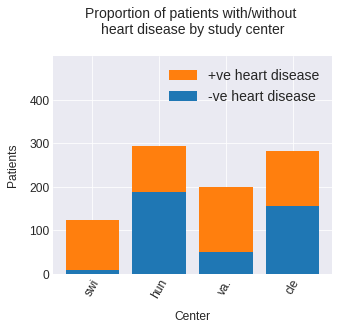

In [160]:
# Graph target vector by center
centers = ['swi', 'hun', 'va.', 'cle']
feature = 'src'
f_0, f_1 = get_bar_data(feature, centers)
fig, ax = plt.subplots(figsize=(5,4))
plot_bar(f_0, f_1, centers, 'Center', np.arange(0, 500, 100), (0, 500),
              'Proportion of patients with/without \nheart disease by study center' )
plt.show()

### Review datasets

In [161]:
print(f'Data')
print(f'====')
print(f'features: {heart_df.shape[1]}')
print(f'observations: {heart_df.shape[0]}')
display(heart_df.head())

Data
====
features: 48
observations: 899


,src,label_bin,age,sex,painloc,painexer,relrest,cptype,restbp,htn,chol,cigsday,cigsyrs,fastsug,famhist,restecg,dig,prop,nitr,pro,diuretic,thaldur,thaltime,met,thalach,thalrest,tpeakbps,tpeakbpd,trestbpd,exang,xhypo,oldpeak,slope,rldv5,rldv5e,ca,thal,label,lmt,ladprox,laddist,diag,cxmain,ramus,om1,om2,rcaprox,rcadist
0,cle,0.0,63.0,1.0,NaN,NaN,NaN,1.0,145.0,1.0,233.0,50.0,20.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,10.5,6.0,13.0,150.0,60.0,190.0,90.0,85.0,0.0,0.0,2.3,3.0,NaN,172.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,cle,1.0,67.0,1.0,NaN,NaN,NaN,4.0,160.0,1.0,286.0,40.0,40.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,9.5,6.0,13.0,108.0,64.0,160.0,90.0,90.0,1.0,0.0,1.5,2.0,NaN,185.0,3.0,3.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,cle,1.0,67.0,1.0,NaN,NaN,NaN,4.0,120.0,1.0,229.0,20.0,35.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,8.5,6.0,10.0,129.0,78.0,140.0,80.0,80.0,1.0,0.0,2.6,2.0,NaN,150.0,2.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,cle,0.0,37.0,1.0,NaN,NaN,NaN,3.0,130.0,0.0,250.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,13.0,13.0,17.0,187.0,84.0,195.0,68.0,78.0,0.0,0.0,3.5,3.0,NaN,167.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,cle,0.0,41.0,0.0,NaN,NaN,NaN,2.0,130.0,1.0,204.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,7.0,NaN,9.0,172.0,71.0,160.0,74.0,86.0,0.0,0.0,1.4,1.0,NaN,40.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 ## EDA

### Attributes can be grouped by clinical stage and purpose:

**Data source (clinical center)**
0. Source (the center where the data was recorded
    (hun = Hungarian Institute Cardiology, 
    swi = University Hospitals Zurich & Basel, 
    cle = Cleveland Clinic Foundation, 
    va = Veterans Medical Center Long Beach)

**Patient demographics**
1. age: age of patient in years
2. sex: sex of patient (1 = male, 0 = female)

**Clinical descriptin of chest pain**
3. painloc: location of chest pain at presentation (1 = substernal, 0 = not substernal)
4. painexer: pain provoked by exertion or not (1 = exertional, 0 = not exertional)
5. pain relieved by rest (1 = yes, 0 = no) 
6. cptype: the clinical impression of the patient's pain 
    (1 = typical angina pain, 2 = atypical angina, 3 = non-anginal, 4 = no pain)

**Patient risk factors for cardiac disease**
7. restbp: patients systolic BP at presentation (mmHg)
8. htn: history of hypertension (1 = yes, 0 = no)
9. chol: patient's serum choleserol level at presentation (in mg/dl)
10. cigdays: number of cigarettes smoked per day
11. cigyrs: number of years a smoker
12. fastsug: fasting blood sugar > 120mg/dl (1 = yes, 0 = no)
13. fam hist: family history heart disease (1 = yes, 0 = no)

**Interpretation of resting ecg**
14. restecg: interpretation of resting ECG result at presentation 
    (0 = normal, 1 = ST-T changes associated with cardiac disease, 3 = left ventricular hypertrophy by Estes' criteria)

**Exercise test**
The next set of features relates to conditions and the results of an exercise test, presumably performed after admission to hospital. While the data entries vary considerably between centers it appears that over 90% of patinest did have an exercise tst of some sort.
15. Whether the patient took digitalis during the exercise test (1 = yes, 0 = no).
16. Whether the patient took beta_blocker during the exercise test (1 = yes, 0 = no).
17. Whether the patient took nitrates during the exercise test (1 = yes, 0 = no).
18. Whether the patient took clcium channel blocker during the exercise test (1 = yes, 0 = no).
19. Whether the patient took diuretcs during the exercise test (1 = yes, 0 = no). 
20. thaldur: duration of the exercise test (mins)
21. thaltime: time into the exercise test when ST changes were first noted on the ecg (mins)
22. met: exercise capacity of the patient in terms of estimated metabolic equivalents of task (METs). 
23. thalach: maximum heartrate achieved during exercise (beats/min)
24. thalrest: resting heartrate before exercise (beats/min)
25. tpeakbps: peak systolic blood pressure (BP) during exercise (mmHg)
26. tpeakbpd: peak diastolic BP during exercise (mmHg)
27. trestbpd: diastolic BP at rest (mmHg)
28. exang: presence of exercise induced angina (yes = 1, 0 = no)
29. xhypo: presumed presence of exercise induced hypotension (1 = yes, 0 = no)
30. oldpeak: ecg evidence of ST-depression during the exercise test (1 = yes, 0 = no)
31. slope: the slope of the ecg ST-segment at peak exercise during the test
    (1 = upsloping, 2 = flat, 3 = downsloping)
32. rldv5: height of the ST segment at rest (mm)
33. rldv5e height of the ST-segment at peak exercise during the test (mm)
34. thal: the result of the myocardial perfusion scintigraphy portion of the exercise thallium scan 
    (3 = normal cardaic wall motion, 6 = fixed wall motion defect, 7 = reversible wall motion defect)

**Coronary flouroscopy**
Results from one further cardiac investigation were also included in the data from some of the centers:
35. ca: number of major coronary vessels coloured during coronary flouroscopy (0 - 3)


### Some basic EDA

In [162]:
heart_df.describe()

,label_bin,age,sex,painloc,painexer,relrest,cptype,restbp,htn,chol,cigsday,cigsyrs,fastsug,famhist,restecg,dig,prop,nitr,pro,diuretic,thaldur,thaltime,met,thalach,thalrest,tpeakbps,tpeakbpd,trestbpd,exang,xhypo,oldpeak,slope,rldv5,rldv5e,ca,thal,label,lmt,ladprox,laddist,diag,cxmain,ramus,om1,om2,rcaprox,rcadist
count,899.000000,899.000000,899.000000,617.000000,617.000000,613.000000,899.000000,839.000000,865.000000,697.000000,479.000000,467.000000,809.000000,477.000000,897.000000,831.000000,833.000000,834.000000,836.000000,817.000000,843.000000,446.000000,794.000000,844.000000,843.000000,836.000000,836.000000,840.000000,844.000000,841.000000,837.000000,591.000000,474.000000,757.000000,291.000000,422.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000
mean,0.550612,53.480534,0.790879,0.920583,0.593193,0.672104,3.253615,132.258641,0.476301,247.807747,19.118998,18.796574,0.166873,0.563941,0.603122,0.034898,0.283313,0.266187,0.172249,0.112607,8.655872,5.690359,16.483123,137.298578,75.487544,171.641148,87.293062,83.523810,0.390995,0.026159,0.870490,1.766497,14.398734,54.914135,0.697595,5.018957,1.129032,0.047831,0.241379,0.180200,0.076752,0.219132,0.042269,0.123471,0.024472,0.249166,0.120133
std,0.497709,9.435894,0.406908,0.270607,0.491637,0.469830,0.928499,18.610596,0.499727,58.529738,18.296273,16.359145,0.373093,0.496415,0.803669,0.183631,0.870965,0.442228,0.377823,0.316306,3.746617,3.994673,30.772801,25.965959,14.727961,25.734488,14.734586,10.252563,0.488263,0.159704,1.080548,0.621339,5.702942,60.309425,1.052728,1.949388,1.259720,0.213527,0.428158,0.384568,0.266346,0.413889,0.201315,0.329160,0.154594,0.432771,0.325299
min,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,1.000000,80.000000,0.000000,85.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,60.000000,37.000000,84.000000,11.000000,0.000000,0.000000,0.000000,-2.600000,0.000000,2.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,47.000000,1.000000,1.000000,0.000000,0.000000,3.000000,120.000000,0.000000,211.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,3.000000,5.000000,120.000000,65.000000,155.000000,80.000000,80.000000,0.000000,0.000000,0.000000,1.000000,10.000000,12.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,54.000000,1.000000,1.000000,1.000000,1.000000,4.000000,130.000000,0.000000,240.000000,20.000000,20.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.100000,6.000000,7.000000,140.000000,74.000000,170.000000,88.000000,80.000000,0.000000,0.000000,0.500000,2.000000,14.000000,19.000000,0.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,60.000000,1.000000,1.000000,1.000000,1.000000,4.000000,140.000000,1.000000,277.000000,30.000000,30.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,10.500000,8.000000,10.000000,157.000000,84.000000,190.000000,100.000000,90.000000,1.000000,0.000000,1.500000,2.000000,18.000000,102.000000,1.000000,7.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,77.000000,1.000000,1.000000,1.000000,1.000000,4.000000,200.000000,1.000000,603.000000,99.000000,60.000000,1.000000,1.000000,2.000000,1.000000,22.000000,1.000000,1.000000,1.000000,24.000000,20.000000,200.000000,202.000000,139.000000,240.000000,134.000000,120.000000,1.000000,1.000000,6.200000,3.000000,36.000000,270.000000,9.000000,7.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Top five columns with missing data


,Total,Percent
ca,608,67.630701
thal,477,53.058954
thaltime,453,50.389321
cigsyrs,432,48.053393
rldv5,425,47.274750


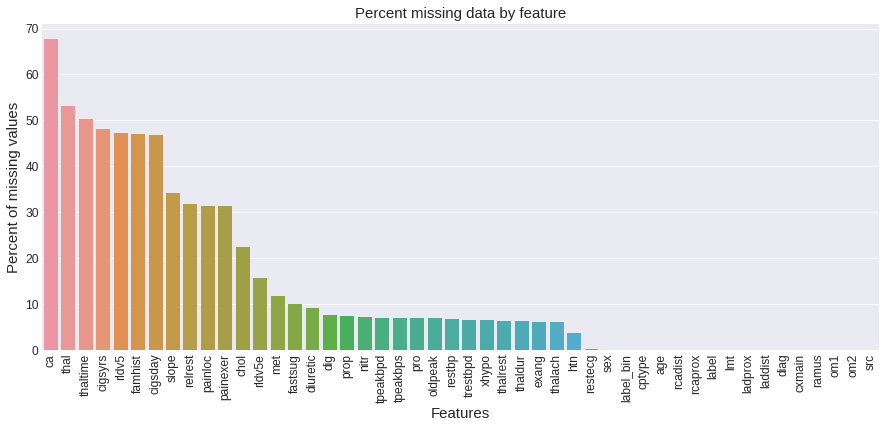

In [163]:
total = heart_df.isnull().sum().sort_values(ascending=False)
percent = ((heart_df.isnull().sum()/heart_df.isnull().count())*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
print('Top five columns with missing data')
missing_data.head()

There are a lot of null values! We deal with null values as part of the data processing pipeline in the companion notebook : UCI Heart Disease Prediction.ipynb

In [164]:
# view corrolation matrix all attributes (excluding non-binary labels and columns with so too many missing values to corrolate)
cols_corr = [c for c in heart_df.columns if c not in label_cols+['restbp', 'ca']]
corr = heart_df[cols_corr].select_dtypes(exclude=np.object).corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,label_bin,age,sex,painloc,painexer,relrest,cptype,htn,chol,cigsday,cigsyrs,fastsug,famhist,restecg,dig,prop,nitr,pro,diuretic,thaldur,thaltime,met,thalach,thalrest,tpeakbps,tpeakbpd,trestbpd,exang,xhypo,oldpeak,slope,rldv5,rldv5e,thal
label_bin,1,0.28,0.32,0.09,0.52,0.45,0.47,0.072,0.13,0.1,0.14,0.14,-0.0023,0.058,-0.021,0.12,0.23,0.2,0.1,-0.29,0.058,0.26,-0.39,-0.22,-0.11,-0.015,-0.0018,0.46,0.12,0.38,0.33,0.087,-0.043,0.48
age,0.28,1,0.064,0.013,0.19,0.2,0.16,0.15,0.086,-0.11,0.14,0.23,-0.064,0.21,0.12,0.12,0.26,0.14,0.22,-0.45,-0.17,0.033,-0.37,-0.21,-0.029,-0.077,0.038,0.2,0.096,0.26,0.14,0.034,0.14,0.11
sex,0.32,0.064,1,0.1,0.22,0.26,0.18,0.035,-0.09,0.31,0.26,0.093,-0.11,-0.012,0.023,0.041,0.08,0.098,0.072,0.16,0.11,0.13,-0.18,-0.2,0.073,0.047,-0.0044,0.2,0.033,0.11,0.13,0.19,-0.098,0.36
painloc,0.09,0.013,0.1,1,0.27,0.33,0.45,-0.0082,0.05,-0.022,-0.13,-0.04,0.047,-0.085,-0.019,0.046,0.13,0.08,0.054,-0.046,-0.063,0.06,-0.14,-0.098,-0.031,0.086,0.1,0.19,0.0071,0.058,0.11,-0.031,0.032,0.068
painexer,0.52,0.19,0.22,0.27,1,0.69,0.83,0.017,0.16,-0.087,-0.027,0.11,0.053,0.022,-0.039,0.11,0.19,0.17,0.17,-0.28,-0.096,0.22,-0.35,-0.22,-0.15,-0.12,0.021,0.41,0.095,0.29,0.13,0.035,0.064,0.22
relrest,0.45,0.2,0.26,0.33,0.69,1,0.81,0.042,0.077,0.015,0.058,0.11,0.012,0.061,-0.012,0.091,0.23,0.2,0.19,-0.24,-0.066,0.11,-0.27,-0.21,-0.13,-0.11,0.029,0.37,0.076,0.27,0.13,0.091,0.11,0.22
cptype,0.47,0.16,0.18,0.45,0.83,0.81,1,0.026,0.11,0.079,0.085,0.031,0.059,0.028,-0.051,0.11,0.23,0.21,0.13,-0.26,-0.0085,0.16,-0.34,-0.18,-0.16,-0.033,0.024,0.41,0.099,0.24,0.2,0.055,-0.032,0.3
htn,0.072,0.15,0.035,-0.0082,0.017,0.042,0.026,1,0.041,0.031,0.1,0.091,0.11,0.092,0.055,0.07,0.1,0.024,-0.013,-0.1,0.014,-0.13,0.025,-0.022,0.032,-0.065,0.11,0.039,-0.024,0.072,-0.088,0.0029,0.13,-0.014
chol,0.13,0.086,-0.09,0.05,0.16,0.077,0.11,0.041,1,-0.05,0.01,0.06,0.087,0.067,-0.083,-0.067,0.017,0.012,-0.039,-0.051,0.064,-0.076,-0.047,0.075,0.072,0.074,0.091,0.095,0.0091,0.049,0.036,-0.096,0.007,0.015
cigsday,0.1,-0.11,0.31,-0.022,-0.087,0.015,0.079,0.031,-0.05,1,0.59,0.0091,-0.018,-0.085,-0.026,-0.044,-0.01,0.037,0.028,-0.012,-0.022,0.036,-0.027,-0.018,0.0082,0.014,0.0059,0.056,-0.063,-0.066,-0.028,-0.12,-0.1,0.16


Not surprisingly, outcome label `label_bin` is most strongly corrolated to the clinical charactersitics of chest pain and the results of exercise testing 'exang and thal'. These attributes also tend to corrolate with each other, while elsewhere corrolations are generally far weaker. 

### 1. Patient demographics

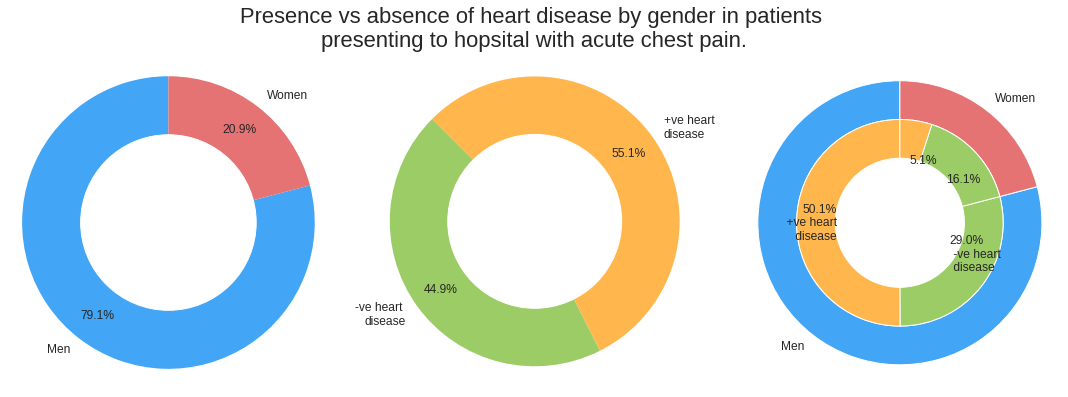

In [165]:
# gender
men = heart_df[heart_df["sex"] == 1].shape[0]
women = heart_df.shape[0] - men

# positive or negative for heart disease (by our criterion of having at least one coronary artery narrowing > 50%)
neg = heart_df[heart_df.label_bin == 0].shape[0]
pos = heart_df.shape[0] - neg

# gender + heart disease
men_neg = heart_df[(heart_df["sex"] == 1) & (heart_df.label_bin == 0)].shape[0]
men_pos = men - men_neg
women_neg = heart_df[(heart_df["sex"] == 0) & (heart_df.label_bin == 0)].shape[0]
women_pos = women - women_neg

perc = [
    str(round(men_pos/8.99, 1)) + "%\n +ve heart\n disease", 
    str(round(men_neg/8.99, 1)) + "%\n -ve heart\n disease \n", 
    str(round(women_neg/8.9, 1)) + "%",
    str(round(women_pos/8.9, 1)) + "%"
]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Presence vs absence of heart disease by gender in patients \npresenting to hopsital with acute chest pain.", fontsize=22, y=1.1)
mpl.rcParams['font.size'] = 12.0

# circle for donut chart
circle0 = plt.Circle( (0,0), 0.6, color = 'white')
circle1 = plt.Circle( (0,0), 0.4, color = 'white')
circle2 = plt.Circle( (0,0), 0.6, color = 'white')

# men vs women
ax[0].pie([men, women], labels=["Men", "Women"], colors=["#42A5F5", "#E57373"], autopct='%1.1f%%', pctdistance=0.8, startangle=90)
ax[0].add_patch(circle0)
ax[0].axis('equal')

# neg vs pos for heart disease
ax[1].pie([neg, pos], labels=["-ve heart \ndisease", "+ve heart \ndisease"], colors=["#9CCC65", "#FFB74D"], autopct='%1.1f%%', pctdistance=0.8, startangle=135)
ax[1].add_patch(circle2)
ax[1].axis('equal')  

# gender & heart disease combined
mypie, _ = ax[2].pie([men, women], radius=1.1, labels=["Men", "Women"], colors=["#42A5F5", "#E57373"], startangle=90)
plt.setp( mypie, width=0.3, edgecolor='white')
mypie2, _ = ax[2].pie([ men_pos, men_neg, women_neg, women_pos], radius = 1 - 0.2, labels=perc, labeldistance=0.61, colors = ["#FFB74D", "#9CCC65", "#9CCC65", "#FFB74D"], startangle=90)
plt.setp(mypie2, width=0.3, edgecolor='white')
plt.margins(0,0)

plt.tight_layout()
plt.show()

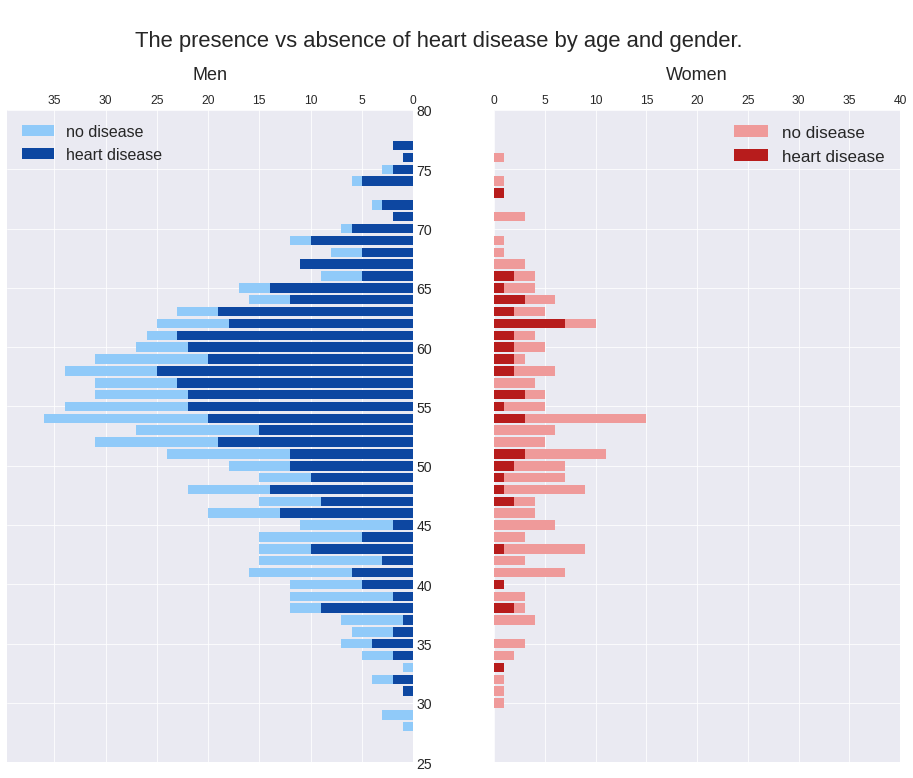

In [166]:
# Histogram of the presence of heart disease by gender and age
bins = [i for i in range(100)]

men_all = np.histogram(heart_df[heart_df.sex == 1]["age"].values, bins=bins)[0]
women_all = np.histogram(heart_df[heart_df.sex == 0]["age"].values, bins=bins)[0]
men_pos = np.histogram(heart_df[(heart_df.sex == 1) & (heart_df.label_bin == 1)]["age"].values, bins=bins)[0]
women_pos = np.histogram(heart_df[(heart_df.sex == 0) & (heart_df.label_bin == 1)]["age"].values, bins=bins)[0]

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(16, 12))
fig.suptitle("\nThe presence vs absence of heart disease by age and gender.\n", fontsize=22, y=1)

axes[0].margins(x=0.1, y=0.01)
m1 = axes[0].barh(bins[:-1], men_all, color='#90CAF9')
m2 = axes[0].barh(bins[:-1], men_pos, color='#0D47A1')
axes[0].set_title('Men', fontsize=18, pad=15)
axes[0].invert_xaxis()
axes[0].set(yticks=[i*5 for i in range(4, 18)])
axes[0].tick_params(axis="y", labelsize=14)
axes[0].yaxis.tick_right()
axes[0].xaxis.tick_top()
axes[0].legend((m1[0], m2[0]), ('no disease', 'heart disease'), loc=2, prop={'size': 16})
axes[0].set_ylim(25,80)
locs = axes[0].get_xticks()

axes[1].margins(y=0.01)
w1 = axes[1].barh(bins[:-1], women_all, color='#EF9A9A')
w2 = axes[1].barh(bins[:-1], women_pos, color='#B71C1C')
axes[1].set_title('Women', fontsize=18, pad=15)
axes[1].xaxis.tick_top()
axes[1].set_xticks(locs)
axes[1].legend((w1[0], w2[0]), ('no disease', 'heart disease'), prop={'size': 17})

plt.show()

### 2. Pain characteristics

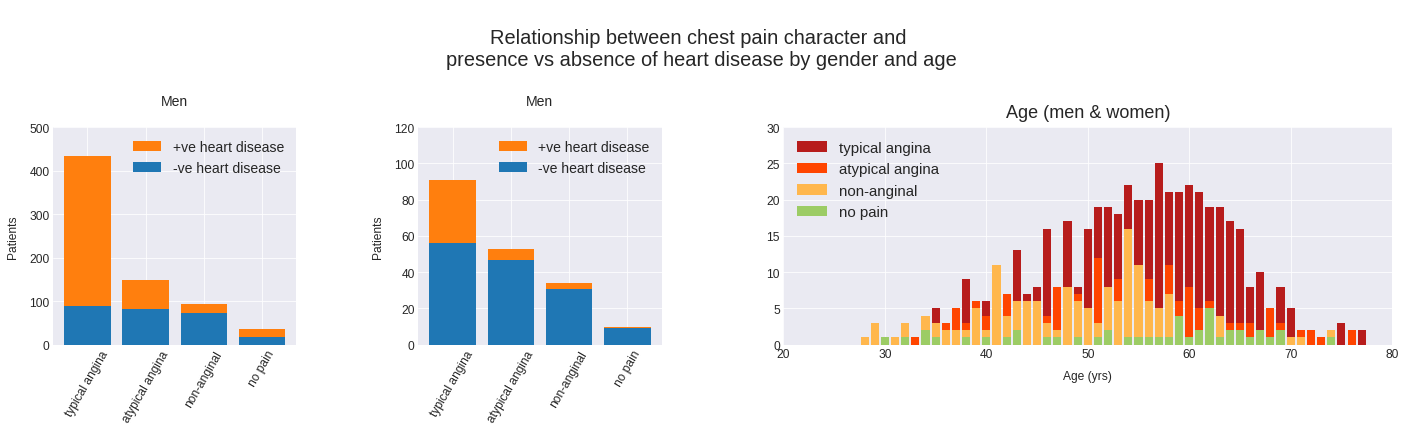

In [167]:
# Characteristic of chest pain by gender and age
men_cp_neg = heart_df[(heart_df.sex == 1) & (heart_df.label_bin == 0)]['cptype'].value_counts()
men_cp_pos = heart_df[(heart_df.sex == 1) & (heart_df.label_bin == 1)]['cptype'].value_counts()
women_cp_neg = heart_df[(heart_df.sex == 0) & (heart_df.label_bin == 0)]['cptype'].value_counts()
women_cp_pos = heart_df[(heart_df.sex == 0) & (heart_df.label_bin == 1)]['cptype'].value_counts()

fig, ax = plt.subplots(1, 4, figsize=(24,4))
x_labels = ('typical angina', 'atypical angina', 'non-anginal', 'no pain')

plt.subplot2grid((1,4),(0,0))
plot_bar([i for i in men_cp_neg], [i for i in men_cp_pos], x_labels, None, np.arange(0, 501, 100), None,'Men')

plt.subplot2grid((1,4),(0,1))
plot_bar([i for i in women_cp_neg], [i for i in women_cp_pos], x_labels, None, np.arange(0, 121, 20), None,'Men')

plt.subplot2grid((1,4),(0,2), colspan=2)
cp_type, cp = [], []
for i in range(4): 
    cp_type.append(np.histogram(heart_df[(heart_df.cptype == i+1) ]["age"].values, bins=bins)[0])
bins = [i for i in range(100)]
colors = ['#9CCC65', '#FFB74D', 'orangered', '#B71C1C']
for i in range(3, -1, -1): 
    cp.append(plt.bar(bins[:-1], cp_type[i], color=colors[i]))
plt.yticks(np.arange(0, 31, 5))
plt.legend((cp[i][0] for i in range(4)), x_labels, prop={'size': 15}, loc='upper left')
plt.xlabel('Age (yrs)', labelpad=10)
plt.title('Age (men & women)', fontsize=18, pad='10')
plt.xlim(20,80)

fig.suptitle("\nRelationship between chest pain character and \npresence vs absence of heart disease by gender and age\n", fontsize=20, y=1.3)
fig.subplots_adjust(wspace=.5, hspace=.6)
fig.show()

### 3. Patient risk factors

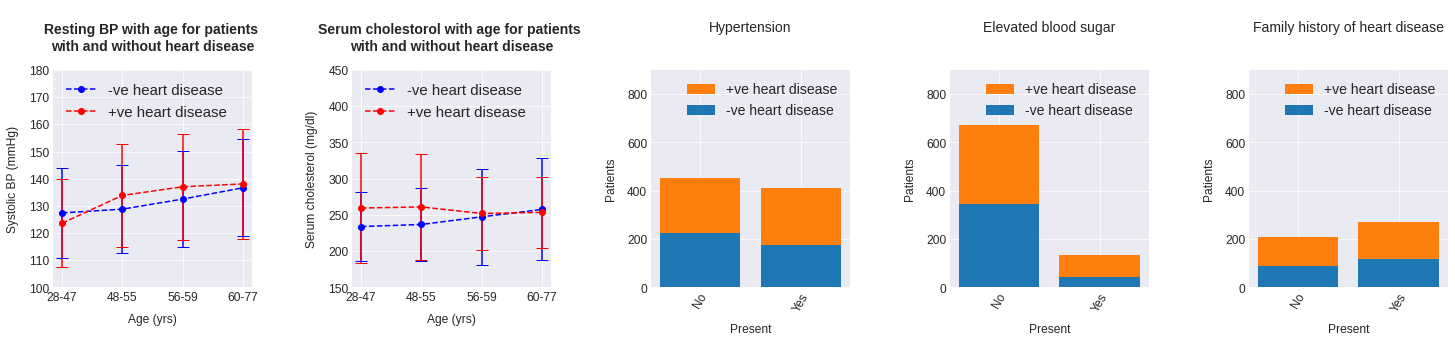

In [168]:
def get_stats(f):
    heart_df['age_q'] = pd.qcut(heart_df['age'], 4)
    means = []
    errs = []
    for i in range(2):
        means.append(np.array(heart_df[heart_df.label_bin==i].groupby('age_q')[f].mean())) 
        errs.append(np.array(heart_df[heart_df.label_bin==i].groupby('age_q')[f].std()))
    return means, errs

fig, ax = plt.subplots(figsize=(25,4))
feats = ['restbp', 'chol']
y_label = ['Systolic BP (mmHg)', 'Serum cholesterol (mg/dl)']
y_lim = [(100, 180), (150, 450)]
x_ticks = ['28-47','48-55','56-59','60-77']
titles = ["\nResting BP with age for patients \nwith and without heart disease",
        "Serum cholestorol with age for patients \nwith and without heart disease"]

for i, f in enumerate(feats):
    means, errs = get_stats(f)
    plt.subplot(1,5,1+i)
    plot_line(x_ticks, means, errs, y_label[i], y_lim[i], titles[i])
    
# Plot binary variable 'htn', 'fastsug' and 'famhist'
feats = ['htn', 'fastsug', 'famhist']
bars = [("No", "Yes"), ("No", "Yes"), ("No", "Yes")]
values = [(0,1), (0,1), (0,1)]
titles = ["Hypertension", "Elevated blood sugar", "Family history of heart disease"]

for i, f in enumerate(feats):
    f_0, f_1 = get_bar_data(f, values[i])
    plt.subplot(1,5,3+i)
    plot_bar(f_0, f_1, bars[i], "Present", np.arange(0, 801,200), (0,900), f'{titles[i]}\n')
    
fig.subplots_adjust(wspace=.5, hspace=.6)
plt.show()
heart_df.drop('age_q', axis=1, inplace=True)

Older patients with raised blood pressure and younger patients with raised cholesterol at presentation appear more likelty to have cardiac disease. IN addition a raised blood sugar at presentation also appear related to increased chance of heart disease. Surprinsingly there appears to be no corrolation between a history of hypertension or a family history of cardiac disease with cardaic disease in the patients in theis study.

Lest drop the uncorrolated columns from furher analysis

In [0]:
 heart_df.drop(['htn', 'famhist'], axis=1, inplace=True)

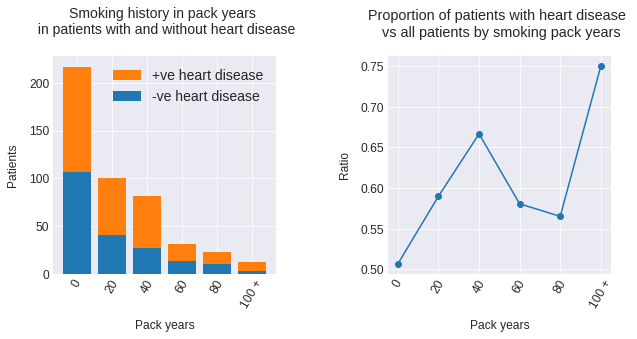

In [170]:
# smoking
# clinicians measure smkoking in 'pack years' where 10 pack years = 20cigs/day smoked for ten years
heart_df['pack_yrs'] = (heart_df.cigsday/20)*heart_df.cigsyrs
pack_yrs_neg = heart_df[heart_df.label_bin == 0]['pack_yrs'].clip(0, 100)
pack_yrs_pos = heart_df[heart_df.label_bin == 1]['pack_yrs'].clip(0, 100)
bins = [i*20 for i in range(7)]
f_0 = np.histogram(pack_yrs_neg, bins=bins)
f_1 = np.histogram(pack_yrs_pos, bins=bins)
labels = ['0', '20', '40', '60', '80', '100 +']
plot_dual(f_0[0], f_1[0], labels, 'Pack years', y_lim_line=(0.4,0.8), \
          title_bar='Smoking history in pack years \n in patients with and without heart disease', \
          title_line='Proportion of patients with heart disease \n vs all patients by smoking pack years') 

As expected, 'pack years' of smoking  corrolates well with heart disease so lets keep it as a feature and remove 'cigsday' and 'cigsyrs'

In [0]:
heart_df.drop(['cigsday', 'cigsyrs', 'pack_yrs'], axis=1, inplace=True)

### Resting ECG appearance

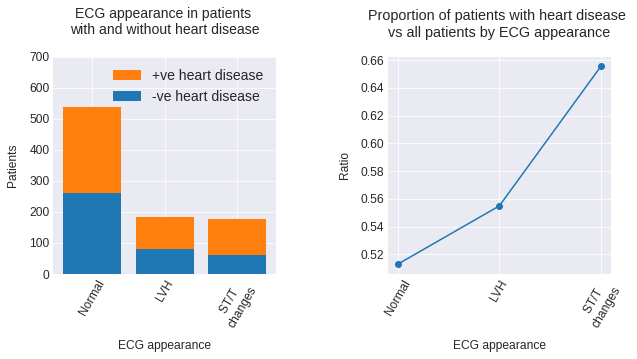

In [172]:
# Resting ecg appearance
labels = ['Normal', 'LVH', 'ST/T \nchanges']
vals = [0,2,1]
f_0, f_1 = get_bar_data('restecg', vals)
plot_dual(f_0, f_1, labels, "ECG appearance", y_lim_bar=(0,700), y_lim_line=(0.4,0.8), \
          title_bar='ECG appearance in patients \nwith and without heart disease', \
          title_line='Proportion of patients with heart disease \nvs all patients by ECG appearance')                                  

There is surprisingly little corrolation between the resting ecg of patients presenting with chest pain and outcome. This goes against clinical intuition but may be due to the exact manner and time patients were recruited. We will drop this attribute from further analysis

In [0]:
heart_df.drop('restecg', axis=1, inplace=True)

### Exercise test

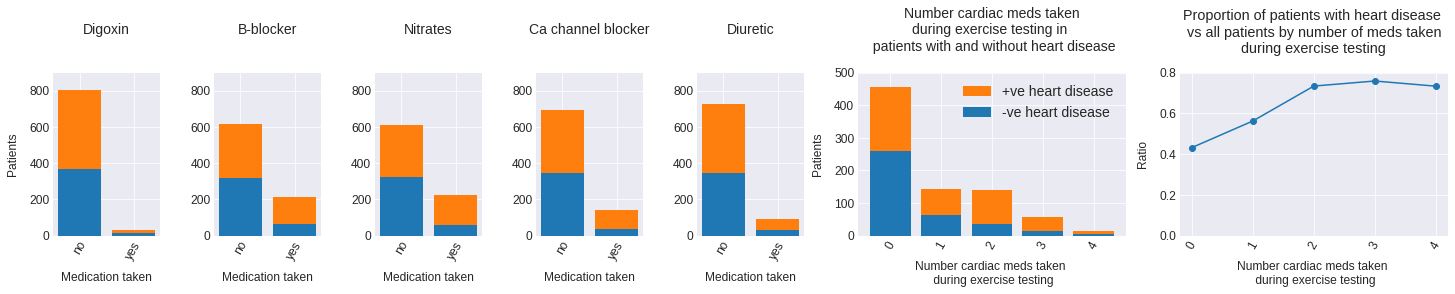

In [174]:
# medications taken during exercise test
fig, ax = plt.subplots(1, 9, figsize=(25,3))

feats = ['dig', 'prop', 'nitr', 'pro', 'diuretic']
vals = [0, 1]
titles = ['Digoxin', 'B-blocker', 'Nitrates', 'Ca channel blocker', 'Diuretic']
for i, f in enumerate(feats):
    f_0, f_1 = get_bar_data(f, vals)
    plt.subplot2grid((1,9),(0,i))
    plot_bar(f_0, f_1, ["no", "yes"],"Medication taken", None, (0,900), f'{titles[i]}\n', legend=False, show_ylabel=True if i==0 else False)
    
plt.subplot2grid((1,9),(0,5), colspan=2)
heart_df['meds_score'] = (heart_df['dig']+heart_df['prop']+heart_df['nitr']+heart_df['pro']+heart_df['diuretic'])
vals = [0,1,2,3,4]
f_0, f_1 = get_bar_data('meds_score', vals)
plot_bar(f_0, f_1, None, "Number cardiac meds taken \n during exercise testing", None, (0,500), \
         f'Number cardiac meds taken\nduring exercise testing in \n patients with and without heart disease')

plt.subplot2grid((1,9),(0,7), colspan=2)
f_ratio = get_ratio(f_0, f_1)
plot_ratios(f_ratio, None, "Number cardiac meds taken \n during exercise testing", (0.0, 0.8), \
        "Proportion of patients with heart disease \nvs all patients by number of meds taken\nduring exercise testing")

fig.subplots_adjust(wspace=.5, hspace=.6)
plt.show()


Patients who already take CV medications either already have a previous diagnosis of cardaic disease or have risk factors for cardiac disease. Ideally, a patients cardiac medications are stopped before exercise testing but this is rarely practical and so the both the fact that the patient is on CV medications, and that these cannot be stopped for exercise testing, are likely indicators of underlying cardiac disease. This is born out by the strong corrolation between the number of CV medications taken by the patient and the increasing likelyhood of cardiac disease in this dataset.

We will drop the individual medication columns but keep their aggregate column, `meds_score`.

In [0]:
heart_df.drop(['dig', 'prop', 'nitr', 'pro', 'diuretic'], axis=1, inplace=True)

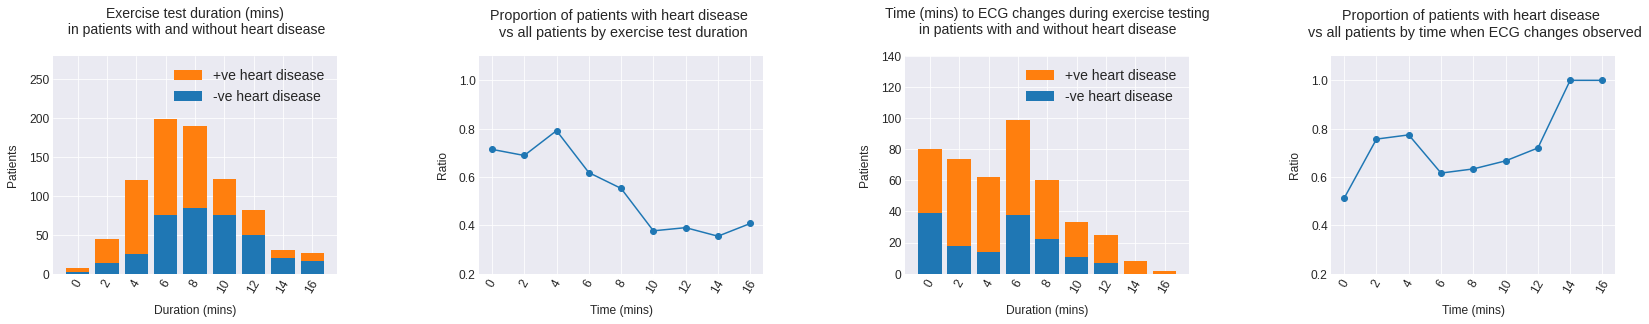

In [176]:
# exercise test duration
feats = ['thaldur', 'thaltime'] 
ylims=[(0, 280), (0, 140)]
titles = [f'Exercise test duration (mins)\n in patients with and without heart disease',
         "Proportion of patients with heart disease \n vs all patients by exercise test duration",
          f'Time (mins) to ECG changes during exercise testing\nin patients with and without heart disease',
         "Proportion of patients with heart disease \n vs all patients by time when ECG changes observed",
         ]
fig, ax = plt.subplots(figsize=(28,4))

for i, f in enumerate(feats):
    f_neg = heart_df[heart_df.label_bin == 0][f].clip(0,20)
    f_pos = heart_df[heart_df.label_bin == 1][f].clip(0,20)
    bins = [i*2 for i in range(10)]
    f_0 = np.histogram(f_neg, bins=bins)
    f_1 = np.histogram(f_pos, bins=bins)

    plt.subplot(1,4,1+i*2)
    plot_bar(f_0[0], f_1[0], f_0[1], 'Duration (mins)', None, ylims[i], titles[2*i])
    
    plt.subplot(1,4,2+i*2)
    f_ratio = get_ratio(f_0[0], f_1[0])
    plot_ratios(f_ratio, f_0[1], 'Time (mins)', (0.2, 1.1), titles[2*i+1])
    
fig.subplots_adjust(wspace=.5, hspace=.6)
plt.show()


There is a negative corrolation between exercise test duration and heart disease explained by the fact that clinically significant cardiac disease often limits a patients's exercise tolerance. An association between time to ECG changes and cardiac disease is less convincing and we shall drop this column. 

In [0]:
heart_df.drop('thaltime', axis=1, inplace=True)

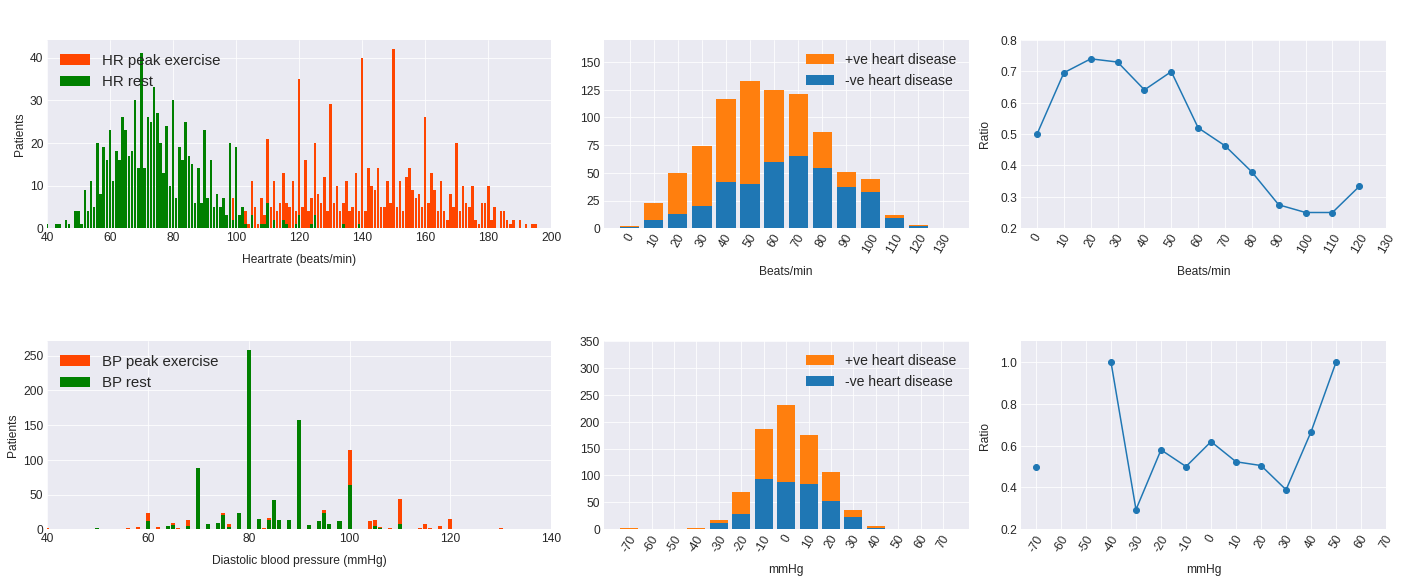

In [178]:
def get_hist_data(f1, f2, r):
    bins = [i for i in range(r)]
    f_0 = np.histogram(heart_df[f1].values, bins=bins)[0]
    f_1 = np.histogram(heart_df[f2].values, bins=bins)[0]
    return f_0, f_1, bins

def get_diff_data(r, f1, f2):
    bins = [i*10 for i in range(r[0], r[1])]
    diff = heart_df[f1] - heart_df[f2]
    diff_neg = diff[heart_df.label_bin==0]
    diff_pos = diff[heart_df.label_bin==1]
    f_0 = np.histogram(diff_neg[diff_neg.notnull()].clip(r[0]*10, r[1]*10), bins=bins)[0]
    f_1 = np.histogram(diff_pos[diff_pos.notnull()].clip(r[0]*10, r[1]*10), bins=bins)[0]
    return f_0, f_1, bins
                           
fig, ax = plt.subplots(2, 10, figsize=(24, 9))

plt.subplot2grid((2,10),(0, 0), colspan=4)
f_0, f_1, bins = get_hist_data('thalach', 'thalrest', 200)
plot_hist(f_0, f_1, bins, (40,200), 'Heartrate (beats/min)', ('HR peak exercise', 'HR rest'), '')

plt.subplot2grid((2,10),(0, 4), colspan=3)
f_0, f_1, bins = get_diff_data([0,15], 'thalach', 'thalrest')
plot_bar(f_0, f_1, bins[:-1], 'Beats/min', None, [0,170], '', show_ylabel=False)

plt.subplot2grid((2,10),(0, 7), colspan=3)
f_ratio = get_ratio(f_0, f_1)
plot_ratios(f_ratio, bins, 'Beats/min', (0.2, 0.8), '')
         
plt.subplot2grid((2,10),(1, 0), colspan=4)
f_0, f_1, bins = get_hist_data('tpeakbpd', 'trestbpd', 200)
plot_hist(f_0, f_1, bins, (40,140), 'Diastolic blood pressure (mmHg)', ('BP peak exercise', 'BP rest'), '' )

plt.subplot2grid((2,10),(1, 4), colspan=3)
f_0, f_1, bins = get_diff_data([-7,9], 'tpeakbpd', 'trestbpd')
plot_bar(f_0, f_1, bins[:-1], 'mmHg', None, [0,350], '',  show_ylabel=False)

plt.subplot2grid((2,10),(1, 7), colspan=3)
f_ratio = get_ratio(f_0, f_1)
plot_ratios(f_ratio, bins, 'mmHg', (0.2, 1.1), '')

fig.subplots_adjust(wspace=.6, hspace=.6)
plt.show()

The presence of heart disease appears to corrolate with a smaller rise in heartrate during exercise testing. This may be due to clinically significant cardiac disease limiting cardiac exertion but also perhaps because more patients with cardiac disease will be taking B-blocker medications (which impair heartrate increases) during testing. 

Blood pressure changes during execise testing doesn't appear related to cardaic disease and we shall discard those columns ('tpeakbpd', 'trestbpd'). No relationship was seen between peak systolic BP 'tpeakbps' or resting oxygen consumption 'mets' and cardiac disease (data not shown). 

In [0]:
heart_df.drop(['tpeakbpd', 'trestbpd', 'met', 'tpeakbps'], axis=1, inplace=True)

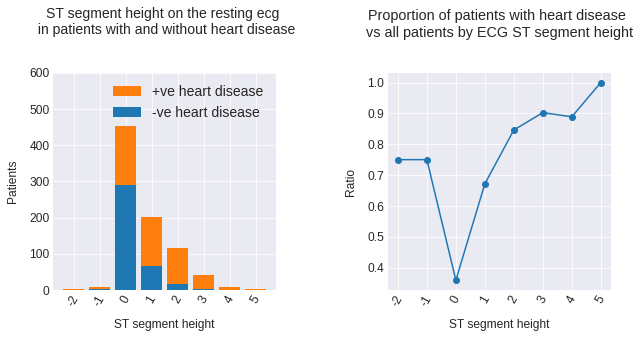

In [180]:
# Peak ECG ST segment changes during exercise testing 
oldpeak_neg = heart_df[heart_df.label_bin == 0]['oldpeak'].clip(-2, 6)
oldpeak_pos = heart_df[heart_df.label_bin == 1]['oldpeak'].clip(-2, 6)
bins = [i for i in range(-2, 7)]
f_0 = np.histogram(oldpeak_neg, bins=bins)
f_1 = np.histogram(oldpeak_pos, bins=bins)
labels = ['-2', '-1', '0', '1', '2', '3', '4', '5', '6']
plot_dual(f_0[0], f_1[0], labels, "ST segment height", y_lim_bar=(0,600), \
          title_bar='ST segment height on the resting ecg \n in patients with and without heart disease\n', \
          title_line='Proportion of patients with heart disease \nvs all patients by ECG ST segment height\n')

ECG ST segment changes provokd by exertion are a sign of cardaic disease. ST segments can either become depressed (below 0) with angina or elevated (above 0) with acute ischaemia and both corrolate with cardiac disease. We will keep this column but take the absolute value so all non zero values carry a similar positive  weight. 

In [0]:
heart_df['oldpeak_abs'] = heart_df['oldpeak'].abs()
heart_df.drop('oldpeak', axis=1, inplace=True)

[78, 120, 13] [257, 76, 47]


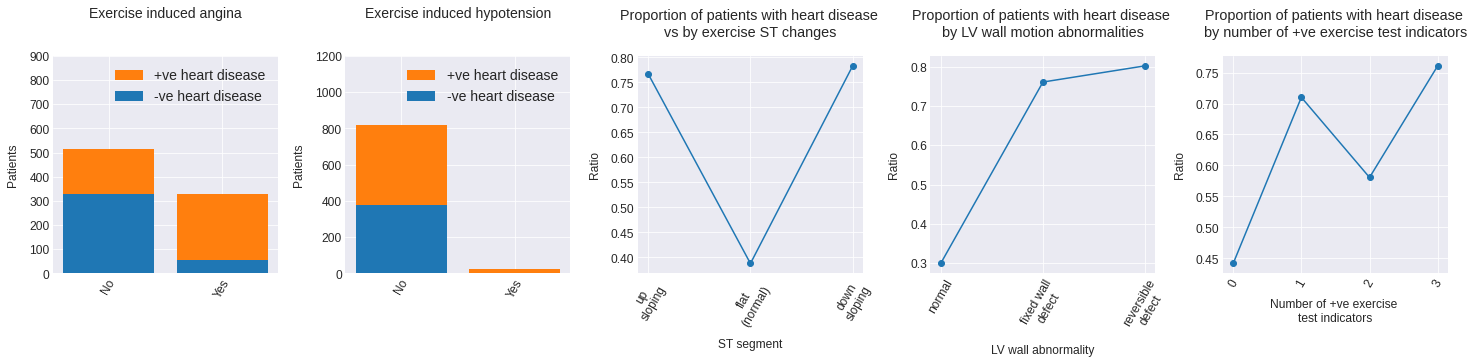

In [182]:
# Indicators of a positive exercise test
fig, ax = plt.subplots(1, 5, figsize=(25,4))
y_lims=[(0,900), (0,1200)]

titles=["Exercise induced angina", "Exercise induced hypotension"]
for i, f in enumerate(['exang', 'xhypo']):
    f_0, f_1 = get_bar_data(f, values[i])
    plt.subplot(1,5,1+i)
    plot_bar(f_0, f_1, bars[i], None, None, y_lims[i], f'{titles[i]}\n')

plt.subplot(1,5,3)
heart_df['slope'] = heart_df['slope'].replace([2,3],[0,2])
f_0, f_1 = get_bar_data('slope', [0.0,1.0,2.0])
print(f_0, f_1)
f_ratio = get_ratio(f_0, f_1)
plot_ratios(f_ratio, ['up\nsloping', 'flat\n(normal)','down\nsloping'], 'ST segment', None, \
            'Proportion of patients with heart disease \nvs by exercise ST changes')

plt.subplot(1,5,4)
heart_df['thal'] = heart_df['thal'].replace([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0], [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0])
f_0, f_1 = get_bar_data('thal', [0.0,1.0,2.0])
f_ratio = get_ratio(f_0, f_1)
plot_ratios(f_ratio, ['normal', 'fixed wall\ndefect','reversible\ndefect'], 'LV wall abnormality', None, \
            'Proportion of patients with heart disease \nby LV wall motion abnormalities')

plt.subplot(1,5,5)
for col in ['exang', 'xhypo', 'thal']: heart_df[col].replace(np.nan, 0)
heart_df['ex_test_sum'] = heart_df['exang']+heart_df['xhypo']+heart_df['thal']
f_0 = heart_df[heart_df.label_bin == 0]['ex_test_sum'].clip(0, 7).value_counts().values
f_1 = heart_df[heart_df.label_bin == 1]['ex_test_sum'].clip(0, 7).value_counts().values
f_ratio = get_ratio(f_0, f_1)
plot_ratios(f_ratio, ['0', '1','2', '3', '4', '5'], 'Number of +ve exercise \ntest indicators', None, \
            'Proportion of patients with heart disease \nby number of +ve exercise test indicators')

fig.subplots_adjust(wspace=.3, hspace=.6)
plt.show()

As expected each indicator of a positive exercise test corrolates strongly with the presence of heart disease. `slope` describs the appearance of the ECG ST segment,: flat is normal, upsloping or downsloping are signs of acute cardiac disease. Ww will keep `slope` but rearrange the values so that '0' means flat and '1' means abnormal (either upsloping or downsloping'). 

In [0]:
heart_df['slope'] = heart_df['slope'].apply(lambda x: 0 if x == 1.0 else 1)

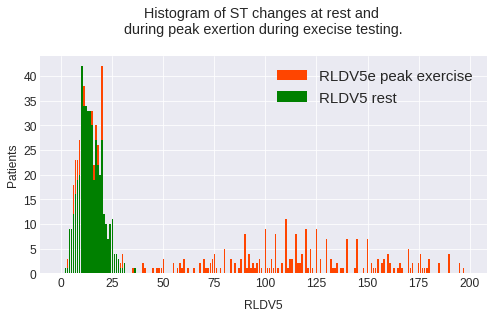

In [184]:
fig, ax = plt.subplots(figsize=(8, 4))

bins = [i for i in range(200)]
f_0 = np.histogram(heart_df.rldv5e.values, bins=bins)[0]
f_1 = np.histogram(heart_df.rldv5.values, bins=bins)[0]
plot_hist(f_0, f_1, bins, None, 'RLDV5', ('RLDV5e peak exercise', 'RLDV5 rest'), \
          'Histogram of ST changes at rest and \nduring peak exertion during execise testing.\n', legend_loc='upper right')
plt.show()

A cohort of patients show changes in height of ST segemnets (rldv5e - rldv5) but the high number of missing values and apparant diffeences in data collection betwen centers hampers corrolation with outcome. Furthermore, it is likely we hve already gained this information from the indicators of a positive exercise test above. Thus we will drop rl5d and rl5de from further analysis.

In [0]:
heart_df.drop(['rldv5', 'rldv5e'], axis=1, inplace=True)

### Flouroscopy

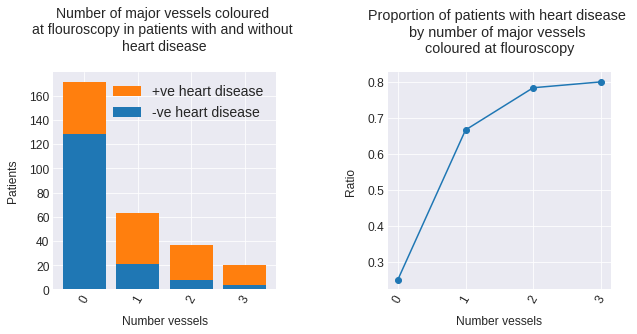

In [186]:
ca_neg = heart_df[heart_df.label_bin == 0]['ca'].clip(0, 3)
ca_pos = heart_df[heart_df.label_bin == 1]['ca'].clip(0, 3)
bins = [i for i in range(0, 5)]
f_0 = np.histogram(ca_neg, bins=bins)
f_1 = np.histogram(ca_pos, bins=bins)
labels = ['0', '1', '2', '3']
plot_dual(f_0[0], f_1[0], labels, "Number vessels", \
          title_bar='Number of major vessels coloured \nat flouroscopy in patients with and without \nheart disease', \
          title_line='Proportion of patients with heart disease \nby number of major vessels \ncoloured at flouroscopy')

A number of patinets in the study (mostly from the Cleveland Center) had coronary flouroscopy performed and the result in terms of number of coronary arteries colored were recorded as the 'ca' attribute. As expected, since flouroscopy is a non-invasive technique for identifying coronary artery narrowings,  this attribute corrolates strongly with cardiac disease. 

## Data cleaning

Using EDA and some basic domain knowledge we have a processed dataset consisting of 16 original attributes and an additional 4 extra attributes derived from the original data. Lets view the corrolations amongst these fial attributes.

W stillk have a lot of missing data so lets clean this up then view the corrolation matris of out new processed and cleaned dataset.

In [187]:
# Impute missing values
print(f'Total missing values before imputing: {heart_df.isnull().sum().sum()}')

# impute missing catagorical values with 0
cols = ["painloc","painexer","relrest","fastsug","meds_score", "oldpeak_abs", "ex_test_sum", "exang", "xhypo", "ca", "thal"]
[heart_df[col].fillna(0, inplace=True) for col in heart_df[cols]]

# impute continuous variable with column mean
cols = ["restbp", "chol", "thaldur","thalach","thalrest",]
[heart_df[col].fillna(heart_df[col].mean(), inplace=True) for col in heart_df[cols]]

print(f'Total missing values After imputing: {heart_df.isnull().sum().sum()}')

# drop the src column
heart_df.drop('src', axis=1, inplace=True)

Total missing values before imputing: 3194
Total missing values After imputing: 0


In [188]:
# view corrolation matrix all attributes (excluding non-binary labels and columns with so too many missing values to corrolate)
print('Processed data')
print('====')
print(f'Num rows: {heart_df.shape[0]}')
print(f'Num cols: {heart_df.shape[1]}')
cols_corr = [c for c in heart_df.columns if c not in label_cols]
corr = heart_df[cols_corr].select_dtypes(exclude=np.object).corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

Processed data
====
Num rows: 899
Num cols: 32


,label_bin,age,sex,painloc,painexer,relrest,cptype,restbp,chol,fastsug,thaldur,thalach,thalrest,exang,xhypo,slope,ca,thal,meds_score,oldpeak_abs,ex_test_sum
label_bin,1,0.28,0.32,0.16,0.43,0.37,0.47,0.11,0.12,0.1,-0.28,-0.38,-0.21,0.43,0.11,0.17,0.12,0.28,0.2,0.37,0.3
age,0.28,1,0.064,-0.054,0.098,0.082,0.16,0.24,0.076,0.22,-0.44,-0.36,-0.21,0.16,0.086,0.0029,0.18,0.13,0.21,0.21,0.14
sex,0.32,0.064,1,0.2,0.24,0.26,0.18,0.0095,-0.084,0.078,0.15,-0.18,-0.2,0.17,0.028,0.099,-0.062,0.15,0.063,0.091,0.13
painloc,0.16,-0.054,0.2,1,0.6,0.67,0.23,0.025,0.0016,-0.0084,0.021,-0.34,-0.02,0.12,0.016,0.41,-0.39,-0.25,0.021,-0.098,-0.26
painexer,0.43,0.098,0.24,0.6,1,0.8,0.6,0.063,0.085,0.057,-0.17,-0.41,-0.14,0.3,0.074,0.22,-0.23,-0.053,0.13,0.13,-0.053
relrest,0.37,0.082,0.26,0.67,0.8,1,0.56,0.057,0.03,0.051,-0.13,-0.37,-0.12,0.26,0.057,0.26,-0.26,-0.085,0.12,0.069,-0.091
cptype,0.47,0.16,0.18,0.23,0.6,0.56,1,0.013,0.096,0.013,-0.25,-0.33,-0.17,0.4,0.096,0.078,0.07,0.2,0.21,0.24,0.23
restbp,0.11,0.24,0.0095,0.025,0.063,0.057,0.013,1,0.079,0.14,-0.18,-0.1,0.0034,0.15,0.063,0.076,0.036,0.075,-0.017,0.14,0.083
chol,0.12,0.076,-0.084,0.0016,0.085,0.03,0.096,0.079,1,0.048,-0.045,-0.038,0.065,0.082,0.0072,0.0057,0.058,0.015,-0.048,0.048,0.031
fastsug,0.1,0.22,0.078,-0.0084,0.057,0.051,0.013,0.14,0.048,1,-0.096,-0.023,0.0073,-0.0036,-0.0061,0.049,0.034,0.052,0.048,-0.0084,0.022


## Machine learning pipeline

Prepare the final dataset for machine learning

In [0]:
# Dummify (one hot encode) nominal data with > 2 catagories
class Dummifier(TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
    def transform(self, df):
        X = df.copy()
        if set(self.cols).issubset(X.columns):
            return pd.get_dummies(X, columns=self.cols)
        else:
            missing_cols = list(set(self.cols)-set(X.columns))
            print(f'Dummifier error: attribute(s) {missing_cols} not found')
            present_cols = [col for col in self.cols if col not in missing_cols]
            return pd.get_dummies(X, columns=present_cols)
    def fit(self, *_):
        return self

In [0]:
# Custom Scaler which takes in a list of columns to scale
# ... and outputs a dataframe (rather than an np.array)
class CustomScaler(TransformerMixin):
    def __init__(self, cols='all', scaler="standard"):
        self.cols = cols
        self.scaler = scaler
    def transform(self, df):
        X = df.copy()
        scaler = MinMaxScaler() if self.scaler == "minmax" else StandardScaler()
        cols_to_scale = self.cols if self.cols != 'all' else X.columns
        for col in cols_to_scale:
            if col in X:
                X[col] = scaler.fit_transform(X[col].values.reshape(-1,1))
            else:
                print(f"CustomScaler warning: attribute '{col}' not found")
        return X
    def fit(self, *_):
        return self

In [0]:
cat_cols = ['cptype','thal', 'ca', 'meds_score', 'ex_test_sum']
cont_cols = ['age', 'restbp', 'chol', 'thaldur', 'thalach', 'thalrest', 'oldpeak_abs' ]
pipe = Pipeline([
    ('one-hot-encoder', Dummifier(cat_cols)),
    ("custom_scaler", CustomScaler(cols=cont_cols, scaler='standard')),
    
])

In [0]:
# x train data (remove label columns)
train_cols = [col for col in heart_df.columns if col not in label_cols+['label_bin']]
X = pipe.fit_transform(heart_df[train_cols])

# y labels
y = heart_df.label_bin

In [193]:
X.head()

,age,sex,painloc,painexer,relrest,restbp,chol,fastsug,thaldur,thalach,thalrest,exang,xhypo,slope,oldpeak_abs,cptype_1.0,cptype_2.0,cptype_3.0,cptype_4.0,thal_0.0,thal_1.0,thal_2.0,ca_0.0,ca_1.0,ca_2.0,ca_3.0,ca_9.0,meds_score_0.0,meds_score_1.0,meds_score_2.0,meds_score_3.0,meds_score_4.0,meds_score_5.0,meds_score_24.0,ex_test_sum_0.0,ex_test_sum_1.0,ex_test_sum_2.0,ex_test_sum_3.0,ex_test_sum_4.0
0,1.009418,1.0,0.0,0.0,0.0,0.709110,-0.287533,1.0,0.508599,0.505143,-1.086585,0.0,0.0,1,1.401062,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
1,1.433568,1.0,0.0,0.0,0.0,1.543922,0.741607,0.0,0.232805,-1.165221,-0.805950,1.0,0.0,1,0.634035,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0
2,1.433568,1.0,0.0,0.0,0.0,-0.682244,-0.365204,0.0,-0.042988,-0.330039,0.176270,1.0,0.0,1,1.688697,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,-1.747551,1.0,0.0,0.0,0.0,-0.125703,0.042569,0.0,1.198083,1.976653,0.597222,0.0,0.0,1,2.551603,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,-1.323402,0.0,0.0,0.0,0.0,-0.125703,-0.850647,0.0,-0.456679,1.380095,-0.314840,0.0,0.0,0,0.538156,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


## Classifiers

In [0]:
n_folds = 10
score = 'accuracy'
random_state = 142

In [0]:
# Set a series of parameters to be gridsearched for each classifier 
# For comparisons wee will use the same set of gridsearch parameters throughout the notebook.
lr_params = {'C': [1e-1, 1e0, 1e1, 1e2], "penalty": ['none', 'L2']}
knn_params = {'n_neighbors': [10, 15, 20]}
dt_params = {'max_depth': [None, 1, 3, 5, 7]}
rf_params = {'criterion': ['gini'], 'bootstrap': [True], 'n_estimators': [12, 48, 124, 200], 'max_depth': [None, 6, 12, 24, 48]}
svc_params = {'C': [0.0001, 0.001, 0.10, 0.1]}
xgb_params = {'n_estimators': [24, 48, 124, 256], 'learning_rate': [0.05, 0.1, 0.2], 'num_leaves': [124]} #'max_depth': [None, 4,8,16,24], 
nb_params = {}

In [0]:
# n_fold cross validation
# Note evaluation metric (score) and n_fold are set in 'Set vars' above
def test_params(model, params, X, y, estimator="estimator"):
    grid = GridSearchCV(model, params, error_score=0, scoring=score, cv=n_folds, refit=True) 
    grid.fit(X, y)
    return [estimator, 
            grid.best_score_, 
            grid.best_params_, 
            round(grid.cv_results_['mean_fit_time'].mean(), 3), 
            round(grid.cv_results_['mean_score_time'].mean(), 3) 
           ]

In [197]:
#Find the best results for each classifier
clfs=[]
clfs.append(test_params(LogisticRegression(), lr_params, X, y, estimator='Logistic Regression'))
clfs.append(test_params(KNeighborsClassifier(), knn_params, X, y, estimator='K Neighbors'))
clfs.append(test_params(DecisionTreeClassifier(), dt_params, X, y, estimator='Decision Tree'))
clfs.append(test_params(RandomForestClassifier(), rf_params, X, y, estimator='Random Forest'))
clfs.append(test_params(LinearSVC(), svc_params, X, y, estimator='Support Vector Machine'))
clfs.append(test_params(XGBClassifier(), xgb_params, X, y, estimator='XGBoost'))
clfs.append(test_params(GaussianNB(), nb_params, X, y, estimator='Naive Bayes'))
         
#Display results in a dataframe
title=(f'Comparison of classifiers on manually processed full UCI Heart dataset ({n_folds}-fold cross validation, metric = {score})')
print(title)
print('='*len(title))
clf_cols = ['Estimator', 'Best accuracy', 'Best params', 'Time to fit(s)', 'Time to score(s)']
clf_df = pd.DataFrame(data=clfs, columns = clf_cols)
print(clf_df.to_string(index=False))

Comparison of classifiers on manually processed full UCI Heart dataset (10-fold cross validation, metric = accuracy)
              Estimator  Best accuracy                                                                       Best params  Time to fit(s)  Time to score(s)
 Logistic Regression     0.789850       {'C': 0.1, 'penalty': 'none'}                                                     0.024           0.001           
 K Neighbors             0.797603       {'n_neighbors': 15}                                                               0.005           0.011           
 Decision Tree           0.757566       {'max_depth': 1}                                                                  0.005           0.001           
 Random Forest           0.800949       {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'n_estimators': 124}  0.181           0.010           
 Support Vector Machine  0.800974       {'C': 0.001}                                                        

Best accuracy: 0.806 from random forest classifier. This is slightly below results obtained using more automated feature selection (see companion notebook UCI Heart Diases prediction).